## An introduction to this code
I used Planck all sky intensity data at 350 $\mu$m and 550 $\mu$m wavelengths to fit for the Modified-Blackbody equation, in order to calculate the temperature and optical depth (at 850 $\mu$m). Although the Planck data already included both the temperature and optical depth, the data did not do a background subtraction. Therefore, the temperature and optical depth that were calculated by Planck can have large error if the background intensity is high.

I manually selected the background region around the cloud (in this code I pick the Carina Nebula), calculated the mean background intensity values at 350 $\mu$m and 550 $\mu$m and applied the subtraction to Planck data. Then I did the Modified-Blackbody fits afterwards. 

The data used in this code are: \
550 $\mu$m: https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/previews/HFI_SkyMap_545_2048_R3.01_full/index.html \
350 $\mu$m: https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/previews/HFI_SkyMap_857_2048_R3.01_full/index.html

I also compared the values I calculated from those provided by Planck. The temperature and optical depth given by Planck can be found in:\
https://irsa.ipac.caltech.edu/data/Planck/release_1/all-sky-maps/previews/HFI_CompMap_ThermalDustModel_2048_R1.20/index.html

The required packages for this code are: \
numpy\
astropy\
reproject\
aplpy\
matplotlib\
scipy

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'


import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from reproject import reproject_from_healpix
from astropy import wcs
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const
import aplpy
from astropy import log
import random
from astropy_healpix import HEALPix
from scipy.optimize import curve_fit
from astropy.coordinates import Galactic

In [6]:
def define_region(center_coordinate, size, ra_size=2, dec_size=1, pixel_size=(5 * u.arcsec)):
    '''
        Defines the region of interest using the center and square if
        we don't have an existing file to use.

        center_coordinate: (SkyCoord)
            center of the region 
        size: 
            makes the region size by size 
        ra_size, dec_size:
            defines the aspect ratio, default is 2:1
        pixel_size: 
            default is 5 arcseconds
    '''

    CDELT = pixel_size.to(u.degree).value
    NAXIS1 = int((ra_size*size / (CDELT * u.degree)).cgs.value)
    NAXIS2 = int((dec_size*size / (CDELT * u.degree)).cgs.value)
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -CDELT,
        'CRPIX1': int(NAXIS1 / 2),
        'CRVAL1': center_coordinate.ra.degree,
        'NAXIS1': NAXIS1,
        'CTYPE2': 'DEC--TAN' ,
        'CUNIT2': 'deg',
        'CDELT2': CDELT,
        'CRPIX2': int(NAXIS2 / 2),
        'CRVAL2': center_coordinate.dec.degree,
        'NAXIS2': NAXIS2
    }
    wcs_dict = wcs.WCS(wcs_input_dict)
    _header = wcs_dict.to_header(relax=True)
    template_hdu = fits.ImageHDU(header=_header, data=np.ones((NAXIS2, NAXIS1)))

    return template_hdu


In [7]:
'''
    Read the data. 
    hdulist350[1].data['I_STOKES'] gives the I-stock intensity
    
    The thermal model gives the temperature and optical depth calculated by Planck.
'''

path = '/Users/april/NU/file/'

planck550 = path+'HFI_SkyMap_545_2048_R3.01_full.fits'
planck350 = path+'HFI_SkyMap_857_2048_R3.01_full.fits'

#550
log.info(f"using files: {planck550}")
hdulist550 = fits.open(planck550)
nside = hdulist550[1].header['NSIDE']  
order = hdulist550[1].header['ORDERING']
frame = hdulist550[1].header['COORDSYS']
planck_hp550 = HEALPix(nside=nside, order=order, frame=Galactic())
stokes_I550 = hdulist550[1].data['I_STOKES']

#350
log.info(f"using files: {planck350}")
hdulist350 = fits.open(planck350)
planck_hp350 = HEALPix(nside=nside, order=order, frame=Galactic())
stokes_I350 = hdulist350[1].data['I_STOKES']

#thermal model
planck_Thermal = path+'HFI_CompMap_ThermalDustModel_2048_R1.20.fits'
log.info(f"using files:{planck_Thermal}")
hdulist_thermal = fits.open(planck_Thermal)
planck_thermal_hp = HEALPix(nside=nside, order=order, frame=Galactic())
tau850 = hdulist_thermal[1].data['TAU353']
temp = hdulist_thermal[1].data['TEMP']

INFO: using files: /Users/april/NU/file/HFI_SkyMap_545_2048_R3.01_full.fits [unknown]
INFO: using files: /Users/april/NU/file/HFI_SkyMap_857_2048_R3.01_full.fits [unknown]
INFO: using files:/Users/april/NU/file/HFI_CompMap_ThermalDustModel_2048_R1.20.fits [unknown]


INFO: Auto-setting vmin to -1.040e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.678e+02 [aplpy.core]


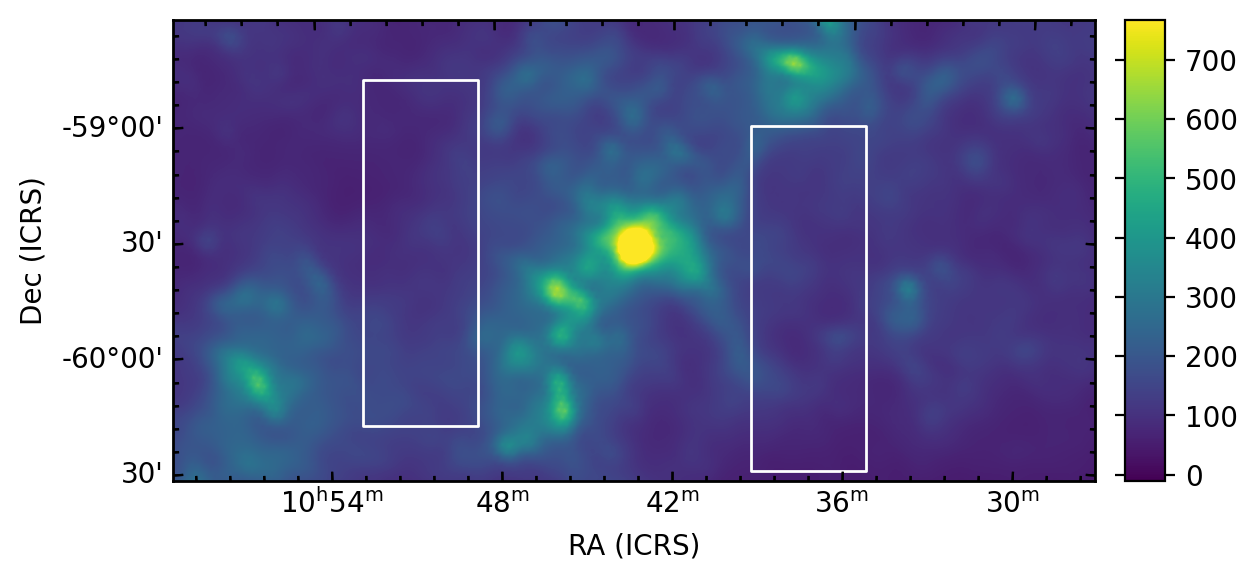

In [10]:
'''
    Finds the background regions for the Carina Nebula
    
    center_coordinate:
        Center of Carina
    left/right_ref_coord:
        the center coordinates for the left and right rectangles which I picked as background
    template_hdu:
        the plotted region
'''

RA = '10:43:20.0'
DEC = '-59:35:15'

center_coordinate = SkyCoord(ra=RA, dec=DEC, frame='icrs', obstime="J2000", unit=(u.hourangle,u.deg))
left_ref_coord = SkyCoord(ra=center_coordinate.ra+(110*u.arcminute), dec=DEC, frame='icrs', obstime="J2000", unit=(u.hourangle,u.deg))
right_ref_coord = SkyCoord(ra=center_coordinate.ra-(90*u.arcminute), dec=center_coordinate.dec-(0.2*u.degree), frame='icrs', obstime="J2000", unit=(u.hourangle,u.deg))

template_hdu = define_region(center_coordinate, size = 2 * u.degree)

'''
    Calculates the mean background intensity in the right and left panels in 550 um and 350 um
    The white rectangles are the chosen background regions 
'''

planck_i, _ = reproject_from_healpix(planck550, template_hdu.header, nested=True, field=0)
planck_i_hdu = fits.ImageHDU(header=template_hdu.header, data=planck_i)
left_hdu = define_region(left_ref_coord, size = 1 * u.degree, ra_size=0.5, dec_size=1.5)
left_ref_i, _ = reproject_from_healpix(planck550, left_hdu.header, nested=True, field=0)
right_hdu = define_region(right_ref_coord, size = 1 * u.degree, ra_size=0.5, dec_size=1.5)
right_ref_i, _ = reproject_from_healpix(planck550, right_hdu.header, nested=True, field=0)
carina_avg_ref_i550 = np.mean(left_ref_i+right_ref_i)

planck_i, _ = reproject_from_healpix(planck350, template_hdu.header, nested=True, field=0)
planck_i_hdu = fits.ImageHDU(header=template_hdu.header, data=planck_i)
left_hdu = define_region(left_ref_coord, size = 1 * u.degree, ra_size=0.5, dec_size=1.5)
left_ref_i, _ = reproject_from_healpix(planck350, left_hdu.header, nested=True, field=0)
right_hdu = define_region(right_ref_coord, size = 1 * u.degree, ra_size=0.5, dec_size=1.5)
right_ref_i, _ = reproject_from_healpix(planck350, right_hdu.header, nested=True, field=0)
carina_avg_ref_i350 = np.mean(left_ref_i+right_ref_i)

mplfig = plt.figure(dpi=100)
fig = aplpy.FITSFigure(planck_i_hdu, figure=mplfig)
fig.show_colorscale(cmap='viridis')
fig.add_colorbar() 
fig.show_rectangles(left_ref_coord.ra,left_ref_coord.dec,0.5*u.degree,1.5*u.degree,color='white')
fig.show_rectangles(right_ref_coord.ra,right_ref_coord.dec,0.5*u.degree,1.5*u.degree,color='white')
mplfig.axes[0].tick_params(which='major', direction='in')
fig.colorbar.set_pad(0.15)

In [11]:
'''
    Defines a function for greybody curve_fit
    
    wav:
        wavelength in micron
    tau0:
        optical depth
    T:
        temperature
        
    The returned intensity value is in [u.Watt*u.m**-2/u.Hz/u.sr]
'''

def Greybody(wav,tau0,T):
    wav = wav*10**-6 #micron to meter
    h,c,k = const.h.value, const.c.value, const.k_B.value
    x = h*c/(k*wav*T)
    wav0 = 850*10**-6
    I = 2*h*c/wav**3 * (np.exp(x)-1)**-1 * (1-np.exp(-tau0*(wav0/wav)**(1.62)))
    return I 


In [13]:
'''
    Do the curve fit to find temperature and optical depth  
    compare the values to those from Planck
    
    I randomly choose 1000 spots from the center 0.6 deg x 0.6 deg region to do the fits
    
    wav and p0:
        wavelength and the guessing values for temperature and optical depth
'''
wav = [350, 550]
p0 = [0.0004, 40]

template_hdu = define_region(center_coordinate, size = 1 * u.degree, ra_size=0.6, dec_size=0.6)
I350, _ = reproject_from_healpix(planck350, template_hdu.header, nested=True, field=0)
I550, _ = reproject_from_healpix(planck550, template_hdu.header, nested=True, field=0)
T, _ =  reproject_from_healpix(planck_Thermal, template_hdu.header, nested=True, field=4)
tau, _ =  reproject_from_healpix(planck_Thermal, template_hdu.header, nested=True, field=0)

num_list = [i for i in range(len(I350.flatten()))]
random_i = np.random.choice(num_list, 1000, replace=False)

f_tau = []
f_T = []
for i in random_i:
    I_350_ = (I350.flatten()[i] - carina_avg_ref_i350) # here I do the background subtraction
    I_550_ = (I550.flatten()[i] - carina_avg_ref_i550)
    center_i = [I_350_,I_550_] * u.MJy/u.sr # Planck provides intensity in u.MJy/u.sr
    try:
        popt_center,_ = curve_fit(f=Greybody,xdata=wav,ydata=center_i.to_value(u.Watt*u.m**-2/u.Hz / u.sr),p0=p0, maxfev=1000)
        f_tau.append(popt_center[0])
        f_T.append(popt_center[1])
    except RuntimeError:
        pass

print('average T and tau from planck are {:.2f}K and {:.5e}'.format(np.mean(T),np.mean(tau)))
print('median of fitted T and tau are {:.2f}K and {:.5e}'.format(np.median(f_T),np.median(f_tau)))


/var/folders/d_/y_m5g_w137jb1_yhnzswxyph0000gn/T/ipykernel_16104/895934489.py:19: RuntimeWarning: overflow encountered in exp
  I = 2*h*c/wav**3 * (np.exp(x)-1)**-1 * (1-np.exp(-tau0*(wav0/wav)**(1.62)))


average T and tau from planck are 38.38K and 2.55449e-04
median of fitted T and tau are 28.16K and 8.37061e-05
